<a href="https://colab.research.google.com/github/DanielFSH/Reproduce-Mechanical-Power/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

In [2]:
# Import libraries
from datetime import timedelta
import os
from sklearn.linear_model import LogisticRegression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')

# Set up environment variables
project_id = 'kind-lab'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )

if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `physionet-data.mimic_core.patients`
WHERE subject_id = 10012853
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df)

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10012853,F,91,2175,2014 - 2016,NaT


In [3]:
df=run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Cohort_exclusion`
ORDER BY subject_id
''')
display(df)

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent
0,10000032,29079034,39553978,0,0,1,0
1,10000980,26913865,39765666,0,0,1,0
2,10001217,24597018,37067082,0,0,1,0
3,10001217,27703517,34592300,0,1,1,0
4,10001725,25563031,31205490,0,0,1,0
...,...,...,...,...,...,...,...
76535,19999442,26785317,32336619,0,0,0,1
76536,19999625,25304202,31070865,0,0,1,0
76537,19999828,25744818,36075953,0,0,1,0
76538,19999840,21033226,38978960,0,0,0,0


In [5]:
Table2_day2 = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Cohort_excludemissing`
''')
#From this join the exclude_missingdata excludes all stays without enough data to calculate MP as 1, 
df2= df.merge(Table2_day2[['stay_id','exclude_missingdata']], on='stay_id', how='left')

In [6]:
final_cohort= df2[(df2['exclude_non_adult'] !=1) & (df2['exclude_secondary_stay'] !=1) & (df2['exclude_tracheostomy'] !=1) & (df2['exclude_short_vent'] !=1)& (df2['exclude_missingdata'] !=1)]

In [7]:
Table1_baseline = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table1_Baseline`
''')
display(Table1_baseline)

,subject_id,Age,Male,Weight,Height,BMI,PBW,adm_elective,adm_urgent,adm_medical,...,adms_internal,adms_emergency,adms_surgery,adms_transfer,adms_other,eth_black,eth_hispanic,eth_white,eth_other,COPD
0,10004720,61,1,70.0,183.0,20.902386,64.13,0,0,1,...,0,0,0,0,1,0,0,1,0,0.0
1,10031757,67,0,117.0,NaN,NaN,NaN,0,0,1,...,0,0,0,0,1,0,0,1,0,0.0
2,10038688,46,1,88.0,178.0,27.774271,59.58,0,1,0,...,1,0,0,0,0,0,0,1,0,0.0
3,10065354,20,0,62.4,NaN,NaN,NaN,0,1,0,...,1,0,0,0,0,0,0,1,0,0.0
4,10074826,63,0,88.0,NaN,NaN,NaN,0,0,1,...,0,0,0,0,1,0,0,0,1,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53098,19970466,83,0,82.0,160.0,32.031250,38.70,0,0,1,...,0,0,0,0,1,0,0,1,0,1.0
53099,19970947,74,0,50.0,160.0,19.531250,38.70,0,1,0,...,0,0,0,0,1,0,0,1,0,0.0
53100,19972786,75,1,70.0,170.0,24.221453,52.30,0,0,1,...,0,0,0,0,1,1,0,0,0,0.0
53101,19982989,73,1,82.0,NaN,NaN,NaN,0,0,1,...,0,0,0,0,1,0,0,1,0,1.0


In [8]:
 Table1_baselinefinal = final_cohort.merge(Table1_baseline, on='subject_id', how='left')

I was unable to code a way to generate the Tables from the paper, I made the tables manually using the information below

In [9]:
Table1_baselinefinal[['Age', 'Weight', 'Height', 'BMI', 'PBW',]].describe()

,Age,Weight,Height,BMI,PBW
count,3117.000000,3117.000000,2757.000000,2756.000000,2756.000000
mean,59.599936,87.099647,169.698498,92.714994,50.221906
std,17.319638,27.385446,12.390111,3183.750820,12.361366
min,18.000000,1.000000,0.000000,12.541432,-99.670000
25%,48.000000,69.500000,163.000000,24.425366,41.430000
50%,61.000000,83.000000,170.000000,28.604765,52.300000
75%,73.000000,100.000000,178.000000,34.312082,59.580000
max,91.000000,345.000000,203.000000,167111.111111,77.830000


In [10]:
Table1_baselinefinal['Male'].value_counts()

adm_elective  adm_urgent  adm_medical
0             0           1              1962
              1           0              1129
1             0           0                26
dtype: int64

In [11]:
Table1_baselinefinal[['adm_elective', 'adm_urgent', 'adm_medical']].value_counts()

adm_elective  adm_urgent  adm_medical
0             0           1              1962
              1           0              1129
1             0           0                26
dtype: int64

In [12]:
Table1_baselinefinal[['eth_black', 'eth_hispanic', 'eth_white', 'eth_other']].value_counts()

eth_black  eth_hispanic  eth_white  eth_other
0          0             1          0            1837
                         0          1             905
1          0             0          0             270
0          1             0          0             105
dtype: int64

In [13]:
Table1_baselinefinal[['adms_internal','adms_emergency','adms_surgery','adms_transfer','adms_other']].value_counts()

adms_internal  adms_emergency  adms_surgery  adms_transfer  adms_other
0              0               0             1              0             1136
               1               0             0              0             1060
               0               0             0              1              910
1              0               0             0              0                8
0              0               1             0              0                3
dtype: int64

In [16]:
Table1_baselinefinal['COPD'].value_counts()

0.0    2832
1.0     285
Name: COPD, dtype: int64

In [21]:
Table1_ARDS = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table1_ARDS`
''')
Table1_ARDSfinal = final_cohort.merge(Table1_ARDS, on='hadm_id', how='left')
Table1_ARDSfinal[['ARD_Mild', 'ARD_Moderate', 'ARD_Severe']].value_counts()

ARD_Mild  ARD_Moderate  ARD_Severe
0.0       0.0           0.0           2038
1.0       0.0           0.0            505
0.0       1.0           0.0            159
          0.0           1.0             15
dtype: int64

In [22]:
Table1_VRRT = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table1_VasoRRT`
''')
Table1_VRRTfinal = final_cohort.merge(Table1_VRRT, on='stay_id', how='left')
Table1_VRRTfinal['Vassopressors'].value_counts()

0    2530
1     587
Name: Vassopressors, dtype: int64

In [23]:
Table1_severity = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table1_severity`
''')
Table1_severityfinal = final_cohort.merge(Table1_severity, on='stay_id', how='left')
Table1_severityfinal[['sapsii', 'oasis','SOFA']].describe()

,sapsii,oasis,SOFA
count,3117.000000,3117.000000,3117.000000
mean,45.806545,42.662817,9.801412
std,16.168901,8.541799,4.286217
min,6.000000,17.000000,0.000000
25%,34.000000,37.000000,6.000000
50%,44.000000,42.000000,10.000000
75%,56.000000,49.000000,13.000000
max,107.000000,71.000000,23.000000


In [24]:
Table1_chartevent = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Day1_chartevents`
''')
Table1_cefinal = final_cohort.merge(Table1_chartevent, on='hadm_id', how='left')
Table1_cefinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,avg_Heartrate,avg_MAP,avg_SpO2,avg_Temp
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3117.000000,2517.000000,3.117000e+03,3039.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,140.361566,389.651768,1.656410e+03,38.031526
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,1503.142015,9519.214856,8.695954e+04,16.664741
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,41.500000,-11.500000,-2.890000e+02,1.333333
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,83.500000,76.000000,9.050000e+01,36.694444
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,94.000000,88.500000,9.400000e+01,37.138889
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,104.000000,122.000000,9.550000e+01,37.611111
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,51080.500000,465015.500000,4.855050e+06,325.472222


In [25]:
Table1_labevent = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Day1_labevents`
''')
Table1_lefinal = final_cohort.merge(Table1_labevent, on='hadm_id', how='left')
Table1_lefinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,avg_pao2fio2ratio,avg_ph,avg_pco2
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,2.978000e+03,2955.000000,2978.000000,2978.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.496447e+07,280.354796,7.358764,43.767461
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.856341e+06,123.200536,0.072337,10.264477
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,25.000000,7.035000,17.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251991e+07,197.250000,7.315000,37.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.501363e+07,255.000000,7.365000,42.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.735032e+07,336.071429,7.410000,48.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,1045.000000,7.585000,125.500000


In [29]:
Table1_Elix = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table1_Elixhauser`
''')
Table1_Elixfinal = final_cohort.merge(Table1_Elix, on='hadm_id', how='left')
Table1_Elixfinal.describe()

,subject_id_x,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,elixhauser_vanwalraven,elixhauser_SID29,elixhauser_SID30
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3117.000000,3117.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,0.393327,0.486686,0.580687
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,1.649851,1.795793,2.163337
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,-4.000000,-4.000000,-5.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,0.000000,0.000000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,0.000000,0.000000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,0.000000,0.000000,0.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,12.000000,13.000000,17.000000


In [32]:
Table2_day1 = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table2_Day1`
''')
Table2_day1final = final_cohort.merge(Table2_day1, on='stay_id', how='left')
Table2_day1final.describe()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,MP,avg_tidal_pbw,avg_peep,avg_plateau,avg_driving,avg_resprate,avg_minutevol,avg_FiO2,NBMA
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3103.000000,2667.000000,3117.000000,3106.000000,3104.000000,3117.000000,3117.000000,3117.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,23.345032,13.804885,7.471756,20.368998,11.798409,22.644851,11.378033,0.633280,0.199230
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,114.593365,146.592077,3.323119,5.883919,5.002065,50.853026,24.510261,0.117359,0.399485
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,-65.405960,-12.328767,2.500000,0.000000,-27.550000,6.000000,2.280000,0.210000,0.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,12.577933,7.864815,5.100000,17.000000,9.500000,16.500000,8.100000,0.550000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,16.628763,9.256462,6.850000,20.000000,11.500000,20.000000,9.600000,0.675000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,21.429844,11.021403,9.000000,23.000000,13.500000,24.000000,11.450000,0.700000,0.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,4609.695815,5423.133236,42.800000,123.000000,115.000000,1769.000000,852.500000,1.000000,1.000000


In [33]:
Table2_day1final['NBMA'].value_counts()

0    2496
1     621
Name: NBMA, dtype: int64

In [35]:
Table2_day2 = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Table2_Day2`
''')
Table2_day2final = final_cohort.merge(Table2_day2, on='stay_id', how='left')
Table2_day2final.describe()

,subject_id,hadm_id,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,MP,avg_tidal_pbw,avg_peep,avg_plateau,avg_driving,avg_resprate,avg_minutevol,avg_FiO2,NBMA
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3117.000000,2667.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,17.301001,13.629036,8.324382,20.631607,11.842262,21.022618,9.677133,0.522007,0.140520
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,36.973076,151.736468,3.762155,5.452098,3.924455,26.046376,5.022747,0.139257,0.347581
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,-42.435470,-15.186585,0.000000,0.000000,-10.000000,5.000000,2.155000,0.210000,0.000000
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,11.585070,7.807039,5.250000,17.000000,9.500000,16.000000,7.750000,0.400000,0.000000
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,15.306816,9.079805,7.500000,20.000000,11.500000,20.000000,9.250000,0.500000,0.000000
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,20.015079,10.744433,10.400000,23.500000,13.700000,24.500000,11.150000,0.650000,0.000000
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,2007.439056,5673.340314,29.000000,124.500000,116.500000,1421.500000,239.500000,1.000000,1.000000


In [36]:
Table2_day2final['NBMA'].value_counts()

0    2679
1     438
Name: NBMA, dtype: int64

In [37]:
Outcomes = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Outcomes`
''')
Outcomes_final = final_cohort.merge(Outcomes, on='stay_id', how='left')
Outcomes_final.describe()

,subject_id_x,hadm_id_x,stay_id,exclude_non_adult,exclude_secondary_stay,exclude_tracheostomy,exclude_short_vent,exclude_missingdata,subject_id_y,hadm_id_y,mort_hosp,mort_ICU,mort_30,mort_year,Vent_free,Hosp_length,ICU_length,seq
count,3.117000e+03,3.117000e+03,3.117000e+03,3117.0,3117.0,3117.0,3117.0,3117.0,3.117000e+03,3.117000e+03,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.000000,3117.0
mean,1.494541e+07,2.494417e+07,3.495907e+07,0.0,0.0,0.0,0.0,0.0,1.494541e+07,2.494417e+07,0.302855,0.278473,0.303176,0.326596,2.274944,19.279115,11.891562,1.0
std,2.848087e+06,2.906278e+06,2.926863e+06,0.0,0.0,0.0,0.0,0.0,2.848087e+06,2.906278e+06,0.459567,0.448319,0.459704,0.469043,13.291988,19.346157,9.977500,0.0
min,1.000561e+07,2.000512e+07,3.000698e+07,0.0,0.0,0.0,0.0,0.0,1.000561e+07,2.000512e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0
25%,1.251970e+07,2.240203e+07,3.237135e+07,0.0,0.0,0.0,0.0,0.0,1.251970e+07,2.240203e+07,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,1.0
50%,1.499892e+07,2.491641e+07,3.498161e+07,0.0,0.0,0.0,0.0,0.0,1.499892e+07,2.491641e+07,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,9.000000,1.0
75%,1.732759e+07,2.745824e+07,3.752145e+07,0.0,0.0,0.0,0.0,0.0,1.732759e+07,2.745824e+07,1.000000,1.000000,1.000000,1.000000,0.000000,24.000000,15.000000,1.0
max,1.999984e+07,2.999910e+07,3.999862e+07,0.0,0.0,0.0,0.0,0.0,1.999984e+07,2.999910e+07,1.000000,1.000000,1.000000,1.000000,346.000000,378.000000,102.000000,1.0


In [38]:
model_chartevent = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Day2_chartevents`
''')
model_cefinal = final_cohort.merge(model_chartevent, on='hadm_id', how='left')
model_labevent = run_query(f'''
SELECT *
FROM `reproduce-mechanical-power.Mechanical_power_tables.Day2_labevents`
''')
model_lefinal = final_cohort.merge(model_labevent, on='hadm_id', how='left')
model_covariates=final_cohort[['subject_id', 'hadm_id','stay_id']].merge(Table2_day2final[['subject_id','MP']], on='subject_id', how='left')
model_covariates=model_covariates.merge(Table1_baselinefinal[['subject_id','Age']], on='subject_id', how='left')
model_covariates=model_covariates.merge(Table1_severityfinal[['subject_id','sapsii','oasis','SOFA']], on='subject_id', how='left')
model_covariates=model_covariates.merge(Table1_Elixfinal[['hadm_id','elixhauser_vanwalraven']], on='hadm_id', how='left')
model_covariates=model_covariates.merge(model_cefinal[['hadm_id','avg_MAP','avg_SpO2', 'avg_Temp']], on='hadm_id', how='left')
model_covariates=model_covariates.merge(model_lefinal[['hadm_id','avg_pao2fio2ratio','avg_ph']], on='hadm_id', how='left')
display(model_covariates)

,subject_id,hadm_id,stay_id,MP,Age,sapsii,oasis,SOFA,elixhauser_vanwalraven,avg_MAP,avg_SpO2,avg_Temp,avg_pao2fio2ratio,avg_ph
0,10005606,29646384,38740124,17.455662,38,33,37,8,0,81.5,95.5,37.583333,262.500000,7.430
1,10007818,22987108,32359580,24.554292,69,81,54,17,0,75.5,96.0,36.322222,205.416667,7.380
2,10016742,29281842,37057036,6.233584,58,18,41,6,0,NaN,94.0,37.333333,NaN,NaN
3,10017531,22580355,35526828,23.558465,63,33,54,5,0,65.5,96.5,37.722222,242.500000,7.370
4,10020944,29974575,30757476,18.470207,72,50,38,10,0,89.5,96.5,36.861111,218.750000,7.340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3112,19970491,25338284,30244200,31.461675,55,54,42,14,0,115.0,93.0,37.444444,218.750000,7.360
3113,19975710,20266816,35393110,11.835264,69,28,33,6,0,NaN,99.5,36.527778,NaN,NaN
3114,19990427,29695607,34058245,14.964404,67,58,54,15,0,NaN,96.5,NaN,355.000000,7.365
3115,19995595,21784060,34670930,15.778686,68,36,39,8,0,79.0,94.5,37.794444,127.500000,7.375


In [39]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imputed_DF = pd.DataFrame(imp.fit_transform(model_covariates))
imputed_DF.columns = model_covariates.columns
imputed_DF.index = model_covariates.index
#The code used to use simple imputer and impute all columns in the dataset was found below
#https://stackoverflow.com/questions/33660836/impute-entire-dataframe-all-columns-using-scikit-learn-sklearn-without-itera


In [41]:
X=imputed_DF.drop(['subject_id','hadm_id','stay_id'], axis=1)
y=Outcomes_final['mort_hosp']
#The code I heavily referenced to get the parameter estimates of the logistic model and then plot it was orgiginally found here
#https://medium.com/@ginoasuncion/visualizing-logistic-regression-results-using-a-forest-plot-in-python-bc7ba65b55bb
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())
logreg = LogisticRegression()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Optimization terminated successfully.
         Current function value: 0.577419
         Iterations 10
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.058     
Dependent Variable:    mort_hosp         AIC:               3621.6290 
Date:                  2022-08-02 01:31  BIC:               3688.1199 
No. Observations:      3117              Log-Likelihood:    -1799.8   
Df Model:              10                LL-Null:           -1911.5   
Df Residuals:          3106              LLR p-value:       2.0156e-42
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        10.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0003   0.0018 -0.1686 0.8661 -0.0038  0.0032
Ag

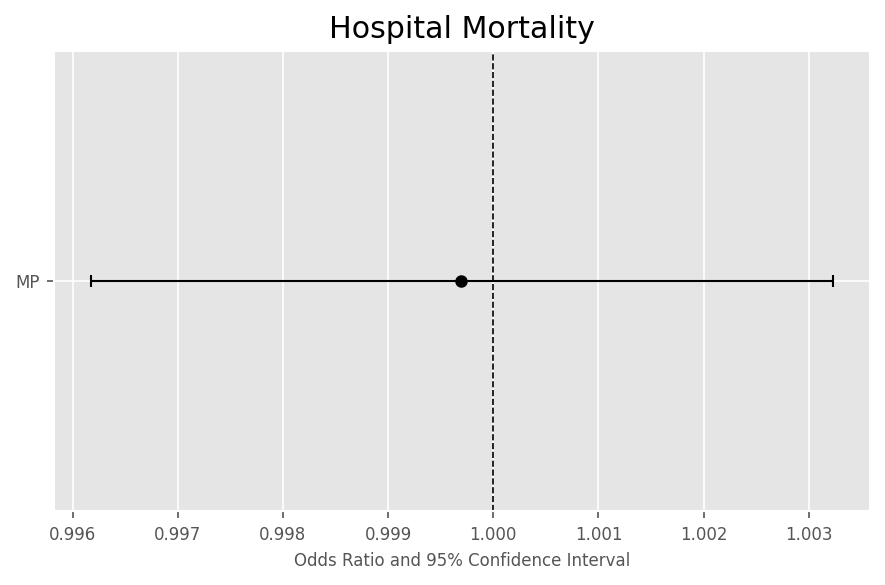

In [44]:
params = result.params
conf = result.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
# check if pvalues are significant
MP=odds.head(1)
MP
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Hospital Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [46]:
#change outcome to ICU mortality
y2=Outcomes_final['mort_ICU']

#logistic model again
logit_model=sm.Logit(y2,X)
result2=logit_model.fit()
print(result2.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.563414
         Iterations 10
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.047     
Dependent Variable:    mort_ICU          AIC:               3534.3204 
Date:                  2022-08-02 01:34  BIC:               3600.8113 
No. Observations:      3117              Log-Likelihood:    -1756.2   
Df Model:              10                LL-Null:           -1843.7   
Df Residuals:          3106              LLR p-value:       2.4077e-32
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        10.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0002   0.0017 -0.0948 0.9244 -0.0034  0.0031
Ag

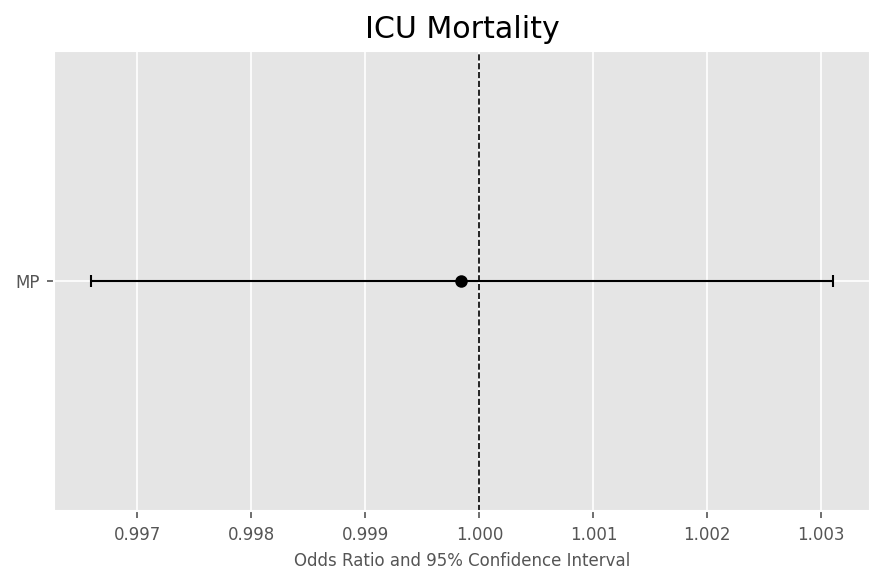

In [47]:
params = result2.params
conf = result2.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('ICU Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [48]:
y3=Outcomes_final['mort_30']
#logistic model again
logit_model=sm.Logit(y3,X)
result3=logit_model.fit()
print(result3.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.579620
         Iterations 14
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.055     
Dependent Variable:    mort_30           AIC:               3635.3485 
Date:                  2022-08-02 01:35  BIC:               3701.8394 
No. Observations:      3117              Log-Likelihood:    -1806.7   
Df Model:              10                LL-Null:           -1912.4   
Df Residuals:          3106              LLR p-value:       6.7046e-40
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        14.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0006   0.0023 -0.2842 0.7762 -0.0051  0.0038
Ag

/usr/local/lib/python3.7/dist-packages/statsmodels/discrete/discrete_model.py:1736: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


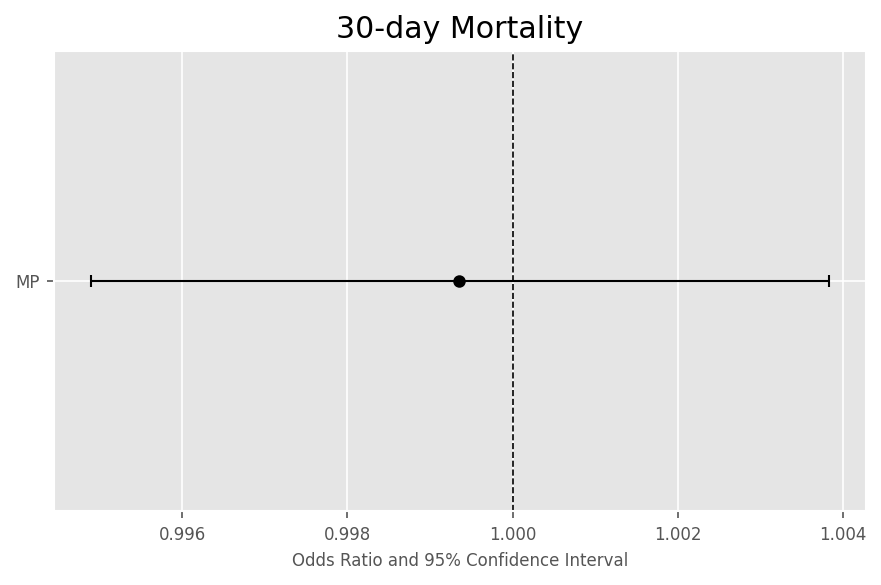

In [49]:
params = result3.params
conf = result3.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('30-day Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [50]:
y4=Outcomes_final['mort_year']
#logistic model again
logit_model=sm.Logit(y4,X)
result4=logit_model.fit()
print(result4.summary2())
logreg = LogisticRegression()

Optimization terminated successfully.
         Current function value: 0.593654
         Iterations 10
                            Results: Logit
Model:                 Logit             Pseudo R-squared:  0.060     
Dependent Variable:    mort_year         AIC:               3722.8360 
Date:                  2022-08-02 01:35  BIC:               3789.3269 
No. Observations:      3117              Log-Likelihood:    -1850.4   
Df Model:              10                LL-Null:           -1969.1   
Df Residuals:          3106              LLR p-value:       2.3589e-45
Converged:             1.0000            Scale:             1.0000    
No. Iterations:        10.0000                                        
----------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
----------------------------------------------------------------------
MP                     -0.0006   0.0021 -0.2771 0.7817 -0.0048  0.0036
Ag

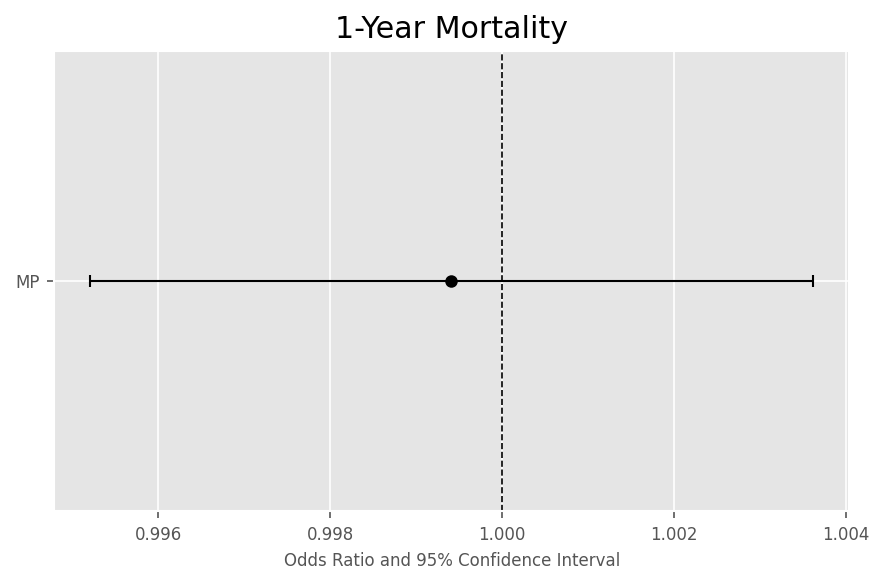

In [51]:
params = result4.params
conf = result4.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('1-Year Mortality')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [54]:
y5=Outcomes_final['Vent_free']
model = sm.OLS(y5, X)
result5 = model.fit()
print(result5.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.036     
Dependent Variable:     Vent_free        AIC:                         24959.6064
Date:                   2022-08-02 01:37 BIC:                         25026.0973
No. Observations:       3117             Log-Likelihood:              -12469.   
Df Model:               11               F-statistic:                 11.60     
Df Residuals:           3106             Prob (F-statistic):          1.64e-21  
R-squared (uncentered): 0.039            Scale:                       175.24    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
MP                        0.0032     0.0064    0.4981   0.6185   -0.0094    0.0158
Age                      -0.0355     0.0159  

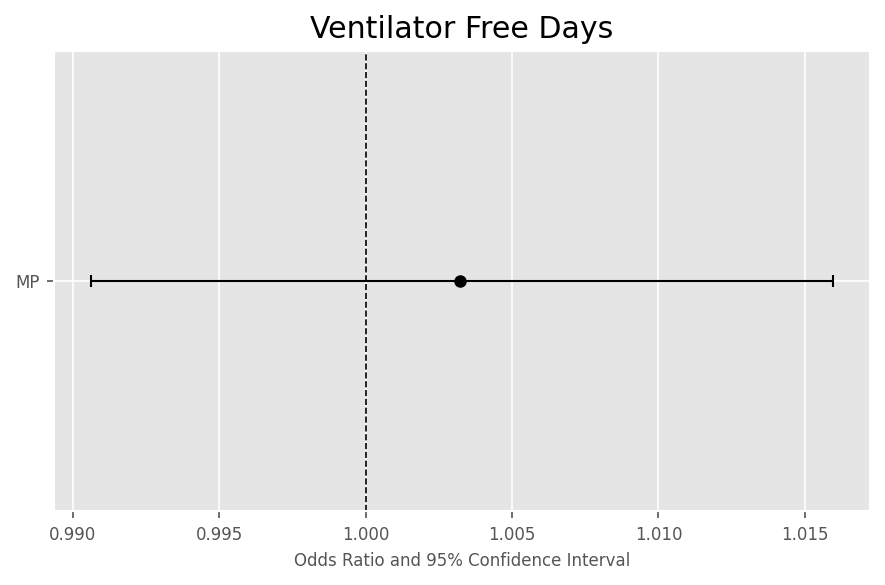

In [55]:
params = result5.params
conf = result5.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Ventilator Free Days')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [58]:
y6=Outcomes_final['ICU_length']
model = sm.OLS(y6, X)
result6 = model.fit()
print(result6.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.603     
Dependent Variable:     ICU_length       AIC:                         23072.3762
Date:                   2022-08-02 01:37 BIC:                         23138.8671
No. Observations:       3117             Log-Likelihood:              -11525.   
Df Model:               11               F-statistic:                 431.4     
Df Residuals:           3106             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.604            Scale:                       95.651    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
MP                        0.0141     0.0048    2.9558   0.0031    0.0047    0.0234
Age                      -0.0026     0.0118  

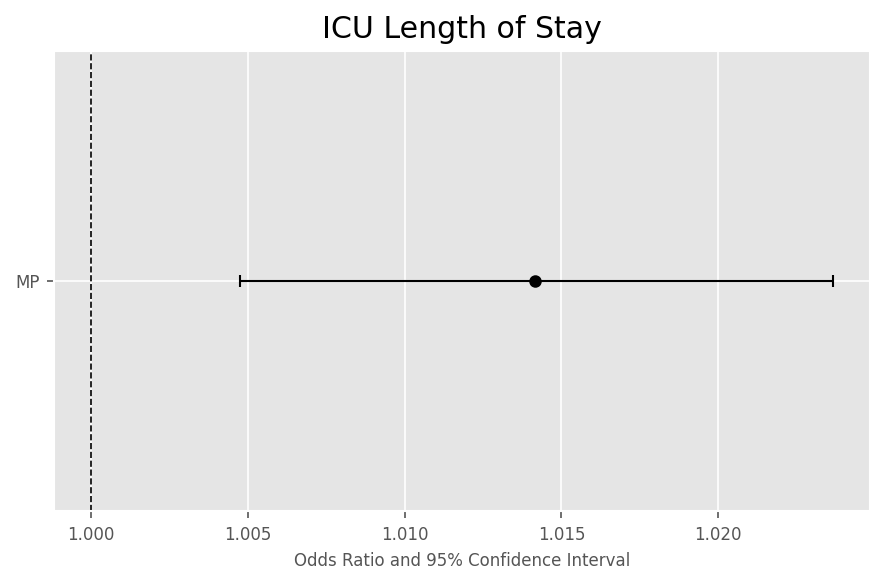

In [63]:
params = result6.params
conf = result6.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('ICU Length of Stay')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

In [61]:
y7=Outcomes_final['Hosp_length']
model = sm.OLS(y7, X)
result7 = model.fit()
print(result7.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.510     
Dependent Variable:     Hosp_length      AIC:                         27251.9654
Date:                   2022-08-02 01:38 BIC:                         27318.4563
No. Observations:       3117             Log-Likelihood:              -13615.   
Df Model:               11               F-statistic:                 295.7     
Df Residuals:           3106             Prob (F-statistic):          0.00      
R-squared (uncentered): 0.512            Scale:                       365.63    
----------------------------------------------------------------------------------
                          Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
----------------------------------------------------------------------------------
MP                        0.0102     0.0093    1.0924   0.2747   -0.0081    0.0284
Age                      -0.0812     0.0230  

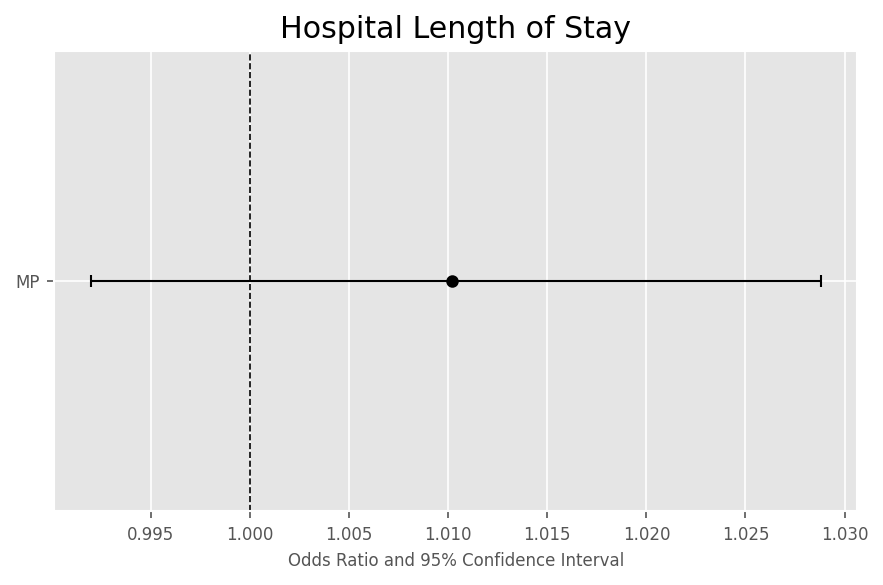

In [64]:
params = result7.params
conf = result7.conf_int()
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']
# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))
MP=odds.head(1)
plt.figure(figsize=(6, 4), dpi=150)
ci = [MP.iloc[::-1]['Odds Ratio'] - MP.iloc[::-1]['2.5%'].values, MP.iloc[::-1]['97.5%'].values - MP.iloc[::-1]['Odds Ratio']]
plt.errorbar(x=MP.iloc[::-1]['Odds Ratio'], y=MP.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.title('Hospital Length of Stay')
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()